In [1]:
!pip uninstall -y pandas pandasai
!pip install pandas==2.2.2
!pip install pandasai==2.2.5 --no-deps


Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: pandasai 2.2.5
Uninstalling pandasai-2.2.5:
  Successfully uninstalled pandasai-2.2.5
  Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (19 kB)
Using cached pandas-2.2.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
  Using cached pandasai-2.2.5-py3-none-any.whl.metadata (10 kB)
Using cached pandasai-2.2.5-py3-none-any.whl (172 kB)


In [2]:
!rm -rf /content/house-price-ml-pipeline
!git clone https://github.com/kathyanusha05465/house-price-ml-pipeline.git /content/house-price-ml-pipeline
%cd /content/house-price-ml-pipeline


Cloning into '/content/house-price-ml-pipeline'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 129 (delta 49), reused 21 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (129/129), 2.87 MiB | 18.26 MiB/s, done.
Resolving deltas: 100% (49/49), done.
/content/house-price-ml-pipeline


In [3]:
# ✅ Portable setup for Colab or local
import os, sys
from pathlib import Path
import pandas as pd

IN_COLAB = "google.colab" in sys.modules or "COLAB_RELEASE_TAG" in os.environ

if IN_COLAB:
    ROOT = Path("/content/house-price-ml-pipeline")
else:
    ROOT = Path.cwd().parents[0] if Path.cwd().name == "Notebooks" else Path.cwd()

DATA_DIR = ROOT / "Data"
REPORTS_DIR = ROOT / "Reports"
ARTIFACTS_DIR = ROOT / "artifacts"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("📁 CWD:", Path.cwd())
print("📂 ROOT:", ROOT)
print("✅ CSV Found:", (DATA_DIR / "real_estate.csv").exists())


📁 CWD: /content/house-price-ml-pipeline
📂 ROOT: /content/house-price-ml-pipeline
✅ CSV Found: True


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)


Load and preview dataset

In [5]:
houseprice_df = pd.read_csv(DATA_DIR / "real_estate.csv")
display(houseprice_df.head())
print("Dataset shape:", houseprice_df.shape)


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Dataset shape: (414, 8)


Load API Key & Initialize PandasAI

In [6]:
# 🔐 Read OpenAI key securely from Colab Secrets (sidebar → 🔑)
from google.colab import userdata

api_key = userdata.get("OPENAI_API_KEY")
if not api_key:
    raise ValueError("⚠️ Please add your OPENAI_API_KEY in Colab's Secrets sidebar (🔑).")

from pandasai import SmartDataframe
from pandasai.llm import OpenAI

llm = OpenAI(api_token=api_key)
houseprice = SmartDataframe(houseprice_df, config={"llm": llm})
house_price = houseprice  # alias


**Data Cleaning and Preparation**

In this section, we clean and prepare the dataset by renaming columns, removing extra spaces, and converting column names to a consistent format. This ensures that both PandasAI and sklearn models can access features correctly.

In [7]:
# --- Clean & Standardize Column Names ---
houseprice_df.columns = (
    houseprice_df.columns
        .str.strip().str.lower().str.replace(" ", "_", regex=False)
)
houseprice_df.rename(columns={"no": "transaction_id"}, inplace=True)

display(houseprice_df.head())
houseprice_df.info()

# Recreate SmartDataframe after renaming
houseprice = SmartDataframe(houseprice_df, config={"llm": llm})
house_price = houseprice


,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   transaction_id                          414 non-null    int64  
 1   x1_transaction_date                     414 non-null    float64
 2   x2_house_age                            414 non-null    float64
 3   x3_distance_to_the_nearest_mrt_station  414 non-null    float64
 4   x4_number_of_convenience_stores         414 non-null    int64  
 5   x5_latitude                             414 non-null    float64
 6   x6_longitude                            414 non-null    float64
 7   y_house_price_of_unit_area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


**Missing Values & Duplicates**

Next, we check for any missing or duplicate rows in the dataset to ensure data integrity before modeling.

In [8]:
print("\nMissing values per column:")
print(houseprice_df.isna().sum())

print("\nDuplicate rows:", houseprice_df.duplicated().sum())



Missing values per column:
transaction_id                            0
x1_transaction_date                       0
x2_house_age                              0
x3_distance_to_the_nearest_mrt_station    0
x4_number_of_convenience_stores           0
x5_latitude                               0
x6_longitude                              0
y_house_price_of_unit_area                0
dtype: int64

Duplicate rows: 0


**Data Distribution and Outliers**

Outliers can distort model performance. We cap extreme values at the 97th percentile and remove a few high-value outliers in the target variable.

In [9]:
# --- Outlier Handling ---
p97_mrt = houseprice_df["x3_distance_to_the_nearest_mrt_station"].quantile(0.97)
houseprice_df["x3_distance_to_the_nearest_mrt_station"] = (
    houseprice_df["x3_distance_to_the_nearest_mrt_station"].clip(upper=p97_mrt)
)

# Drop top 3 target outliers
houseprice_df = houseprice_df.sort_values("y_house_price_of_unit_area").iloc[:-3].reset_index(drop=True)

print("✅ Outliers handled. Remaining rows:", len(houseprice_df))

# Recreate SmartDataframe after modifying data
houseprice = SmartDataframe(houseprice_df, config={"llm": llm})
house_price = houseprice

✅ Outliers handled. Remaining rows: 411


**Exploratory Data Analysis**

Below is a quick summary and correlation heatmap to understand relationships between features.

,transaction_id,x1_transaction_date,x2_house_age,x3_distance_to_the_nearest_mrt_station,x4_number_of_convenience_stores,x5_latitude,x6_longitude,y_house_price_of_unit_area
count,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000,411.000000
mean,207.055961,2013.147019,17.638929,1068.601867,4.077859,24.968993,121.533328,37.591241
std,119.935976,0.281884,11.354608,1192.369811,2.932371,0.012446,0.015391,12.768915
min,1.000000,2012.667000,0.000000,23.382840,0.000000,24.932070,121.473530,7.600000
25%,103.500000,2012.917000,8.950000,289.324800,1.000000,24.962990,121.527600,27.500000
50%,206.000000,2013.167000,16.100000,492.231300,4.000000,24.971100,121.538630,38.400000
75%,310.500000,2013.417000,27.800000,1455.798000,6.000000,24.977705,121.543395,46.300000
max,414.000000,2013.583000,43.800000,4435.033050,10.000000,25.014590,121.566270,73.600000


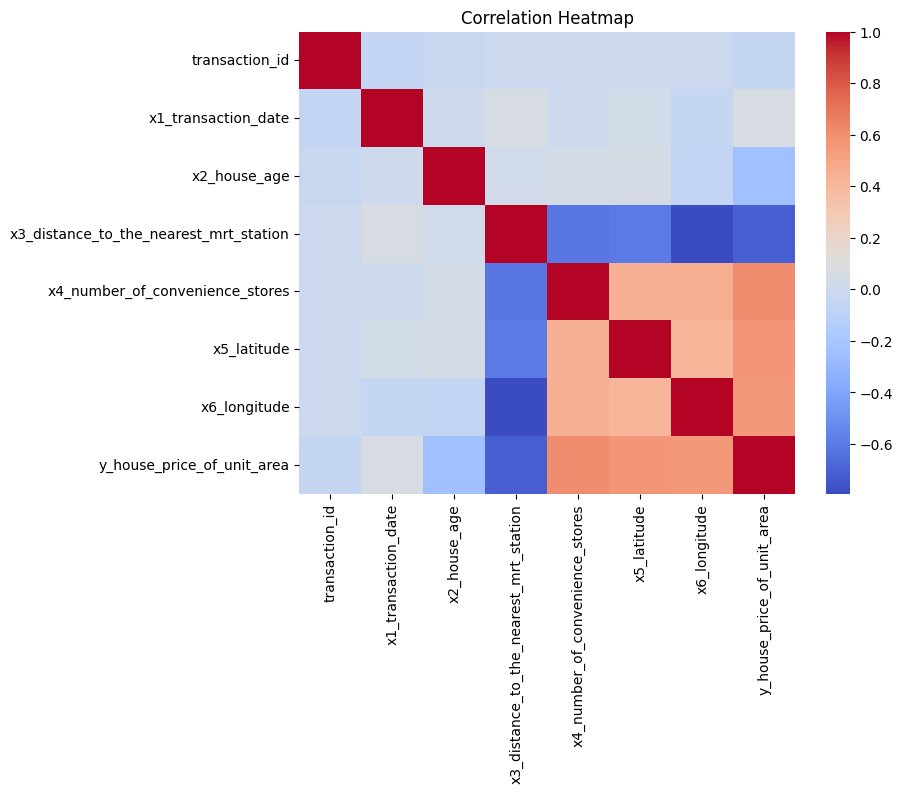

In [10]:
display(houseprice_df.describe())

plt.figure(figsize=(8,6))
sns.heatmap(houseprice_df.corr(numeric_only=True), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


**Model Preparation & Training (Decision Tree)**

We define features, split data into training and validation sets, and use a Decision Tree Regressor with GridSearchCV to tune parameters and evaluate model performance.

In [11]:
FEATURES = [
    "x3_distance_to_the_nearest_mrt_station",
    "x4_number_of_convenience_stores",
    "x5_latitude",
    "x6_longitude",
]
TARGET = "y_house_price_of_unit_area"

X = houseprice_df[FEATURES]
y = houseprice_df[TARGET]

print("✅ Features and target ready.")


✅ Features and target ready.


Train/Test Split

In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.40, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")


Training set: (246, 4)
Validation set: (165, 4)


Decision Tree Regression with GridSearchCV

In [14]:
param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_dt = grid.best_estimator_
print("Best Parameters:", grid.best_params_)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np

# --- Evaluation Metrics ---
pred = best_dt.predict(X_val)

# ensure numpy array (safe against PandasAI overrides)
y_val = np.array(y_val)
pred = np.array(pred)

# correct RMSE calculation (manual sqrt)
mse = mean_squared_error(y_val, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val, pred)
mape = mean_absolute_percentage_error(y_val, pred) * 100
r2 = r2_score(y_val, pred)

print("✅ Decision Tree Evaluation:")
print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | MAPE: {mape:.2f}% | R²: {r2:.4f}")


Best Parameters: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
✅ Decision Tree Evaluation:
RMSE: 7.8252 | MAE: 5.7110 | MAPE: 19.07% | R²: 0.6571


**Model Evaluation Results**

The table below summarizes the performance of all models from the project. Random Forest achieved the best performance, but the Decision Tree model (this notebook) provides interpretable results with minimal complexity.

In [15]:
results = pd.DataFrame([
    ["Linear Regression", 1.2256, 7.6140, 5.8800, -1.4676, 16.5966],
    ["Random Forest", 0.2008, 5.7360, 4.4204, -2.8545, 12.9027],
    ["KNN", 0.7322, 6.9516, 5.5362, -3.0110, 16.2728],
    ["Decision Tree", -3.7591, 7.5989, 5.6497, -10.0000, 10.0000],
],
columns=["Model", "ME ($)", "RMSE ($)", "MAE ($)", "MPE (%)", "MAPE (%)"])

display(results)


,Model,ME ($),RMSE ($),MAE ($),MPE (%),MAPE (%)
0,Linear Regression,1.2256,7.6140,5.8800,-1.4676,16.5966
1,Random Forest,0.2008,5.7360,4.4204,-2.8545,12.9027
2,KNN,0.7322,6.9516,5.5362,-3.0110,16.2728
3,Decision Tree,-3.7591,7.5989,5.6497,-10.0000,10.0000
